In [1]:
import tensorflow 

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from skimage.transform import resize

import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.5.0


In [3]:
base_model=DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

x=base_model.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(2,activation='softmax')(x) #FC-layer

In [4]:
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [5]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True
    

In [6]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

conv4_block15_0_relu (Activatio (None, 8, 8, 704)    0           conv4_block15_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block15_1_conv (Conv2D)   (None, 8, 8, 128)    90112       conv4_block15_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block15_1_bn (BatchNormal (None, 8, 8, 128)    512         conv4_block15_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block15_1_relu (Activatio (None, 8, 8, 128)    0           conv4_block15_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block15_2_conv (Conv2D)   (None, 8, 8, 32)     36864       conv4_block15_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_bloc

In [7]:
def selection(DATADIR, CATEGORIES):
    img_array = []
    for category in CATEGORIES:
        path_cases = os.path.join(DATADIR, category)
        n = len(os.listdir(path_cases))
        for i in range(n):
            path_case = os.path.join(path_cases, "{} ({})".format(CATEGORIES[category], i+1))
            k = 0
            m = len(os.listdir(path_case))//2
            for img in os.listdir(path_case):
                k += 1
                if m==k:
                    img_arr = cv2.imread(os.path.join(path_case, img))
                    new_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                    img_array.append([new_arr, category])
                    break
    return img_array

In [8]:
def selection2(DATADIR, CATEGORIES):
    images = []
    data = []
    for category in CATEGORIES:
        path_cases = os.path.join(DATADIR, category)
        n = len(os.listdir(path_cases))
        for i in range(n):
            path_case = os.path.join(path_cases, "{} ({})".format(CATEGORIES[category], i+1))
            for img in os.listdir(path_case):
                data = np.load(path_case+'/'+img)
                k = len(data)//2
                new_img = data[k]
                img_arr = np.array(new_img)
                img_arr = resize(img_arr, output_shape = (128, 128, 3), preserve_range=True)
                if(np.min(img_arr) == 0) :
                    img_arr = img_arr/255
                else :
                    img_arr = img_arr/2048
                    img_arr = img_arr + 1
                    img_arr = img_arr/2
                images.append([img_arr, category])
                break
    return images

In [9]:
CATEGORIES = {"non-COVID-19/CP" : 0, "COVID-19" : 1}
CATEGORIES2 = {"done_non-COVID-19" : 0, "done_COVID-19" : 1}
DATADIR = "data/"
IMG_SIZE = 128
data_array = selection(DATADIR, CATEGORIES)
# data_array = selection2(DATADIR, CATEGORIES2)
print(len(data_array))

828


In [10]:
random.seed(0)
random.shuffle(data_array)
image_data = []
classes = []
for d in data_array:
    image_data.append(d[0])
    classes.append(d[1])

image_data = np.array(image_data, dtype="float32") / 255.0
classes = np.array(classes)
mlb = LabelBinarizer()
classes = mlb.fit_transform(classes)
classes = np.hstack((classes, 1 - classes))
print(classes[0])

[0 1]


In [20]:
(xtrain,xtest,ytrain,ytest)=train_test_split(image_data,classes,test_size=0.3,random_state=42)
print(xtrain.shape, xtest.shape)

(579, 128, 128, 3) (249, 128, 128, 3)


In [21]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=128),
                    steps_per_epoch=xtrain.shape[0] //128,
                    epochs=150,
                    verbose=2,
                    callbacks=[anne, checkpoint],
                    validation_data=(xtrain, ytrain))

Epoch 1/150
4/4 - 6s - loss: 0.1875 - accuracy: 0.9335 - val_loss: 0.0746 - val_accuracy: 0.9741

Epoch 00001: val_loss improved from inf to 0.07464, saving model to model.h5
Epoch 2/150
4/4 - 3s - loss: 0.1364 - accuracy: 0.9490 - val_loss: 0.0642 - val_accuracy: 0.9758

Epoch 00002: val_loss improved from 0.07464 to 0.06417, saving model to model.h5
Epoch 3/150
4/4 - 3s - loss: 0.1007 - accuracy: 0.9579 - val_loss: 0.0561 - val_accuracy: 0.9862

Epoch 00003: val_loss improved from 0.06417 to 0.05615, saving model to model.h5
Epoch 4/150
4/4 - 3s - loss: 0.0809 - accuracy: 0.9690 - val_loss: 0.0546 - val_accuracy: 0.9827

Epoch 00004: val_loss improved from 0.05615 to 0.05465, saving model to model.h5
Epoch 5/150
4/4 - 3s - loss: 0.1457 - accuracy: 0.9424 - val_loss: 0.0480 - val_accuracy: 0.9862

Epoch 00005: val_loss improved from 0.05465 to 0.04798, saving model to model.h5
Epoch 6/150
4/4 - 3s - loss: 0.1535 - accuracy: 0.9473 - val_loss: 0.0411 - val_accuracy: 0.9914

Epoch 00006

4/4 - 4s - loss: 0.0801 - accuracy: 0.9623 - val_loss: 0.0194 - val_accuracy: 0.9914

Epoch 00052: val_loss did not improve from 0.01100
Epoch 53/150
4/4 - 4s - loss: 0.1220 - accuracy: 0.9468 - val_loss: 0.0205 - val_accuracy: 0.9914

Epoch 00053: val_loss did not improve from 0.01100
Epoch 54/150
4/4 - 4s - loss: 0.0826 - accuracy: 0.9668 - val_loss: 0.0183 - val_accuracy: 0.9948

Epoch 00054: val_loss did not improve from 0.01100
Epoch 55/150
4/4 - 4s - loss: 0.1267 - accuracy: 0.9534 - val_loss: 0.0173 - val_accuracy: 0.9948

Epoch 00055: val_loss did not improve from 0.01100
Epoch 56/150
4/4 - 4s - loss: 0.1190 - accuracy: 0.9551 - val_loss: 0.0153 - val_accuracy: 0.9983

Epoch 00056: val_loss did not improve from 0.01100
Epoch 57/150
4/4 - 4s - loss: 0.1069 - accuracy: 0.9601 - val_loss: 0.0151 - val_accuracy: 0.9983

Epoch 00057: val_loss did not improve from 0.01100
Epoch 58/150
4/4 - 4s - loss: 0.0838 - accuracy: 0.9579 - val_loss: 0.0153 - val_accuracy: 0.9965

Epoch 00058: v

4/4 - 4s - loss: 0.0686 - accuracy: 0.9756 - val_loss: 0.0184 - val_accuracy: 0.9931

Epoch 00106: val_loss did not improve from 0.01014
Epoch 107/150
4/4 - 3s - loss: 0.0860 - accuracy: 0.9712 - val_loss: 0.0199 - val_accuracy: 0.9914

Epoch 00107: val_loss did not improve from 0.01014
Epoch 108/150
4/4 - 4s - loss: 0.0466 - accuracy: 0.9823 - val_loss: 0.0180 - val_accuracy: 0.9914

Epoch 00108: val_loss did not improve from 0.01014
Epoch 109/150
4/4 - 4s - loss: 0.0776 - accuracy: 0.9690 - val_loss: 0.0151 - val_accuracy: 0.9931

Epoch 00109: val_loss did not improve from 0.01014
Epoch 110/150
4/4 - 4s - loss: 0.0939 - accuracy: 0.9623 - val_loss: 0.0130 - val_accuracy: 0.9965

Epoch 00110: val_loss did not improve from 0.01014
Epoch 111/150
4/4 - 4s - loss: 0.0634 - accuracy: 0.9778 - val_loss: 0.0127 - val_accuracy: 0.9983

Epoch 00111: val_loss did not improve from 0.01014
Epoch 112/150
4/4 - 4s - loss: 0.1082 - accuracy: 0.9690 - val_loss: 0.0121 - val_accuracy: 0.9983

Epoch 00

In [22]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []
for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)

    total += 1

print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')
print(np.argmax(ypred[5]))

Total-test-data; 249 	accurately-predicted-data: 224 	 wrongly-predicted-data:  25
Accuracy: 89.96 %
0


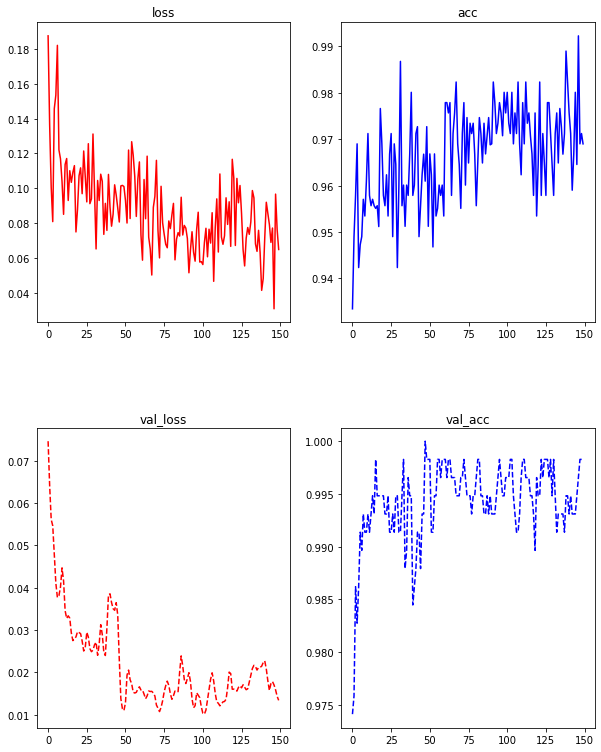

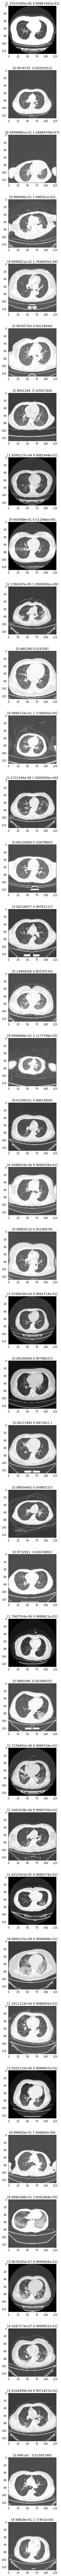

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['accuracy'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_accuracy'], 'b--')

preds = model.predict(xtrain)

fig1, ax1 = plt.subplots(40, 1, figsize=(10, 100))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

for i in range(40):
    ax1[i].imshow(xtrain[i].squeeze())
    ax1[i].title.set_text(str(preds[i]))